In [ ]:
import pandas as pd
TVDI = pd.read_csv('/data/TVDI_model_clear.csv')

In [3]:
TVDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Data              10014 non-null  object 
 1   Hora              10014 non-null  object 
 2   Mes               10014 non-null  int64  
 3   Campanya          10014 non-null  int64  
 4   EAM               10014 non-null  object 
 5   id_pol            10014 non-null  int64  
 6   cat_cultiu        10014 non-null  object 
 7   T                 10014 non-null  float64
 8   Tmax              10014 non-null  float64
 9   Tmin              10014 non-null  float64
 10  H                 10014 non-null  int64  
 11  I                 10014 non-null  float64
 12  Evo               10014 non-null  float64
 13  v                 10014 non-null  float64
 14  Precipitacio_dia  10014 non-null  float64
 15  P                 10014 non-null  float64
 16  P1                10014 non-null  float6

MODEL PINNS

In [4]:
import os, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score, mean_absolute_error
from datetime import timedelta

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

TVDI['Data'] = pd.to_datetime(TVDI['Data'])
TVDI = TVDI.set_index('Data')

# Definició de dia de l'any i creació varaible ciclica

TVDI['D']  = TVDI.index.dayofyear

TVDI['doy_sin']  = np.sin(2 * np.pi * TVDI['D'] / 365)
TVDI['doy_cos']  = np.cos(2 * np.pi * TVDI['D'] / 365)

TVDI = TVDI.dropna()


In [5]:
# Varibales d'entrrada del model
features_num = [
    'T', 'Evo','I', 'VPD','ETc',
    'P', 'PT', 'doy_sin', 'doy_cos', 'H']

# Codificar EAM per entrar com a categorica
le_eam = LabelEncoder()
TVDI['EAM_enc'] = le_eam.fit_transform(TVDI['EAM'])

le_cat = LabelEncoder()
TVDI['cat_enc'] = le_cat.fit_transform(TVDI['cat_cultiu'])

In [6]:
TVDI['Mes_idx'] = TVDI['Mes'] - 1

In [7]:
# Separar entrades
X_num = TVDI[features_num].values
X_cat = TVDI['cat_enc'].values
X_mes = TVDI['Mes_idx'].values
X_eam = TVDI['EAM_enc'].values
y = TVDI['TVDI'].values.reshape(-1, 1)

N_CATEGORIES_MES = 12

In [8]:
# Entrenament/Test
X_num_train, X_num_test, \
X_cat_train, X_cat_test, \
X_mes_train, X_mes_test, \
X_eam_train, X_eam_test, \
y_train, y_test = train_test_split(
    X_num,
    X_cat,
    X_mes,
    X_eam,
    y,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

In [9]:
# Escalar dades numèriques i varaible objectiu
scaler_num = StandardScaler().fit(X_num_train)
X_num_train_scaled = scaler_num.transform(X_num_train)
X_num_test_scaled = scaler_num.transform(X_num_test)

scaler_y = MinMaxScaler().fit(y_train.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [10]:
# Inputs
input_num = Input(shape=(X_num_train_scaled.shape[1],))
input_cat = Input(shape=(1,))
input_eam = Input(shape=(1,))
input_mes = Input(shape=(1,))

features_num = [
    'Tmax', 'Evo','I', 'VPD','ETc',
    'Precipitacio_dia', 'precip_7', 'precip_3', 'doy_sin', 'doy_cos']

In [11]:
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, LeakyReLU
from tensorflow.keras import regularizers

class SimplePINN_TVDI(Model):
    def __init__(self, n_cat, n_eam, n_mes,
                 beta_T=0.0,
                 beta_ETo=0.0,
                 beta_I=0.0,
                 beta_p=0.0,
                 beta_pt=0.0,
                 alpha=0.0):
        super().__init__()
        self.alpha = alpha
        self.beta_T = beta_T
        self.beta_ETo = beta_ETo
        self.beta_I = beta_I
        self.beta_p = beta_p
        self.beta_pt = beta_pt

        self.embedding_cat = Embedding(input_dim=n_cat, output_dim=3)
        self.embedding_eam = Embedding(input_dim=n_eam, output_dim=3)
        self.embedding_mes = Embedding(input_dim=n_mes, output_dim=3)

        self.concat = Concatenate(name='merge_inputs')

        self.dense1 = Dense(256, kernel_regularizer=regularizers.l2(1e-4), name='dense_1')
        self.bn1 = BatchNormalization(name='batch_1')
        self.act1 = LeakyReLU(negative_slope=0.1, name='act_1')
        self.drop1 = Dropout(0.2, name='dropout_1')

        self.dense2 = Dense(128, kernel_regularizer=regularizers.l2(1e-4), name='dense_2')
        self.bn2 = BatchNormalization(name='batch_2')
        self.act2 = LeakyReLU(negative_slope=0.1, name='act_2')
        self.drop2 = Dropout(0.2, name='dropout_2')

        self.dense3 = Dense(64, kernel_regularizer=regularizers.l2(1e-4), name='dense_3')
        self.bn3 = BatchNormalization(name='batch_3')
        self.act3 = LeakyReLU(negative_slope=0.1, name='act_3')
        self.drop3 = Dropout(0.2, name='dropout_3')

        self.output_layer = Dense(1, activation='sigmoid', name='output_TVDI')

    def call(self, inputs, training=False):
        x_num, x_cat, x_eam, x_mes = inputs
        e_cat = Flatten()(self.embedding_cat(x_cat))
        e_eam = Flatten()(self.embedding_eam(x_eam))
        e_mes = Flatten()(self.embedding_mes(x_mes))
        x = self.concat([x_num, e_cat, e_eam, e_mes])
        x = self.drop1(self.act1(self.bn1(self.dense1(x), training=training)), training=training)
        x = self.drop2(self.act2(self.bn2(self.dense2(x), training=training)), training=training)
        x = self.drop3(self.act3(self.bn3(self.dense3(x), training=training)), training=training)
        return self.output_layer(x)

    def train_step(self, data):
      (x_num, x_cat, x_eam, x_mes), y_true = data
      x_num = tf.cast(x_num, tf.float32)
      x_cat = tf.cast(x_cat, tf.int32)
      x_eam = tf.cast(x_eam, tf.int32)
      x_mes = tf.cast(x_mes, tf.int32)
      y_true = tf.cast(y_true, tf.float32)


      with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_num)
        y_pred = self([x_num, x_cat, x_eam, x_mes], training=True)

        # Compute data loss using the compiled loss function
        loss_data = self.compiled_loss(y_true, y_pred, regularization_losses=self.losses)

        idx_T   = 0
        idx_ETo = 1
        idx_Irr = 2
        idx_p = 5
        idx_pt  = 6

        T      = x_num[:, idx_T]
        ETo    = x_num[:, idx_ETo]
        I      = x_num[:, idx_Irr]
        prec_p = x_num[:, idx_p]
        prec_pt = x_num[:, idx_pt]


        grad_all = tape.gradient(y_pred, x_num)
        grad_T     = grad_all[:, idx_T]
        grad_ETo   = grad_all[:, idx_ETo]
        grad_I     = grad_all[:, idx_Irr]
        grad_p = grad_all[:, idx_p]
        grad_pt = grad_all[:, idx_pt]

        mask_no_rain = tf.cast(
              tf.logical_and(tf.equal(prec_p, 0.0), tf.equal(prec_pt, 0.0)),
              tf.float32
          )

        # Penalitzacions
        loss_T     = self.beta_T * tf.reduce_mean(mask_no_rain * tf.nn.relu(-grad_T))
        loss_ETo   = self.beta_ETo * tf.reduce_mean(mask_no_rain * tf.nn.relu(-grad_ETo))
        loss_I     = self.beta_I * tf.reduce_mean(mask_no_rain * tf.nn.relu(-grad_I))
        loss_p = self.beta_p * tf.reduce_mean(tf.nn.relu(grad_p))
        loss_pt = self.beta_pt * tf.reduce_mean(tf.nn.relu(grad_pt))

        loss_mono = loss_T + loss_ETo + loss_I + loss_p + loss_pt

        # Pèrdua total
        loss_total = (1.0 - self.alpha) * loss_data + self.alpha * loss_mono

      # Gradient respecte als pesos
      grads = tape.gradient(loss_total, self.trainable_variables)
      del tape

      # Aplica actualització
      self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

      self.compiled_metrics.update_state(y_true, y_pred)

      metrics_dict = {m.name: m.result() for m in self.metrics}
      metrics_dict.update({
          "loss": loss_total,
          "data_loss": loss_data,
          "loss_mono": loss_mono
      })

      return metrics_dict

    def test_step(self, data):
      (x_num, x_cat, x_eam, x_mes), y_true = data
      x_num = tf.cast(x_num, tf.float32)
      x_cat = tf.cast(x_cat, tf.int32)
      x_eam = tf.cast(x_eam, tf.int32)
      x_mes = tf.cast(x_mes, tf.int32)
      y_true = tf.cast(y_true, tf.float32)

      with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_num)
        y_pred = self([x_num, x_cat, x_eam, x_mes], training=False)

        # Compute data loss using the compiled loss function
        loss_data = self.compiled_loss(y_true, y_pred, regularization_losses=self.losses)

        idx_T   = 0
        idx_ETo = 1
        idx_Irr = 2
        idx_p = 5
        idx_pt  = 6

        T      = x_num[:, idx_T]
        ETo    = x_num[:, idx_ETo]
        I      = x_num[:, idx_Irr]
        prec_p = x_num[:, idx_p]
        prec_pt = x_num[:, idx_pt]


        grad_all = tape.gradient(y_pred, x_num)
        grad_T     = grad_all[:, idx_T]
        grad_ETo   = grad_all[:, idx_ETo]
        grad_I     = grad_all[:, idx_Irr]
        grad_p = grad_all[:, idx_p]
        grad_pt = grad_all[:, idx_pt]

        mask_no_rain = tf.cast(
              tf.logical_and(tf.equal(prec_p, 0.0), tf.equal(prec_pt, 0.0)),
              tf.float32
          )

        # Penalitzacions
        loss_T     = self.beta_T * tf.reduce_mean(mask_no_rain * tf.nn.relu(-grad_T))
        loss_ETo   = self.beta_ETo * tf.reduce_mean(mask_no_rain * tf.nn.relu(-grad_ETo))
        loss_I     = self.beta_I * tf.reduce_mean(mask_no_rain * tf.nn.relu(-grad_I))
        loss_p = self.beta_p * tf.reduce_mean(tf.nn.relu(grad_p))
        loss_pt = self.beta_pt * tf.reduce_mean(tf.nn.relu(grad_pt))

        loss_mono = loss_T + loss_ETo + loss_I + loss_p + loss_pt

        # Pèrdua total
        loss_total = (1.0 - self.alpha) * loss_data + self.alpha * loss_mono


      self.compiled_metrics.update_state(y_true, y_pred)

      metrics_dict = {m.name: m.result() for m in self.metrics}
      metrics_dict.update({
          "loss": loss_total,
          "data_loss": loss_data,
        "loss_mono": loss_mono
     })

      return metrics_dict

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Cambinacions de pesos de cada gradaient.
model = SimplePINN_TVDI(
    n_cat=len(le_cat.classes_),
    n_eam=len(le_eam.classes_),
    n_mes=12,
    beta_T=0.0,
    beta_ETo=0.0,
    beta_I=0.0,
    beta_p=0.0,
    beta_pt=0.0,
    alpha=0.0,
    )

model.compile(
    optimizer=Adam(5e-4),
    loss='mse',
    metrics=['mae']
)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
# Entrenament
history = model.fit(
    x=[X_num_train_scaled, X_cat_train, X_eam_train, X_mes_train],
    y=(y_train_scaled),
    validation_data=([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], (y_test_scaled)),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R² (Validación): 0.902
R (Validación): 0.954
MAE (Validación): 0.051
RMSE (Validación): 0.068


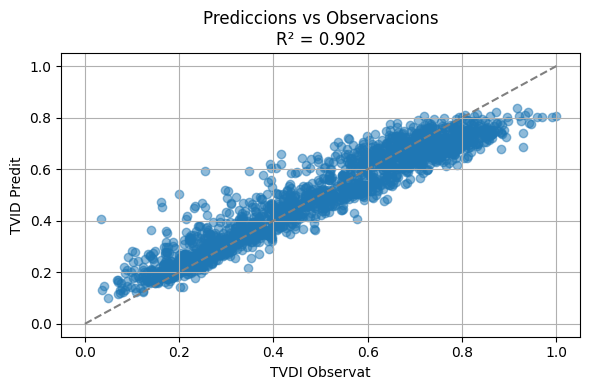

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Predicció
y_pred_scaled = model.predict([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_true = y_test.ravel()


r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r, _ = pearsonr(y_true.ravel(), y_pred.ravel())

print(f"R² (Validación): {r2:.3f}")
print(f"R (Validación): {r:.3f}")
print(f"MAE (Validación): {mae:.3f}")
print(f"RMSE (Validación): {rmse:.3f}") # Imprime el RMSE

# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('TVDI Observat')
plt.ylabel('TVID Predit')
plt.title(f'Prediccions vs Observacions\nR² = {r2:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()

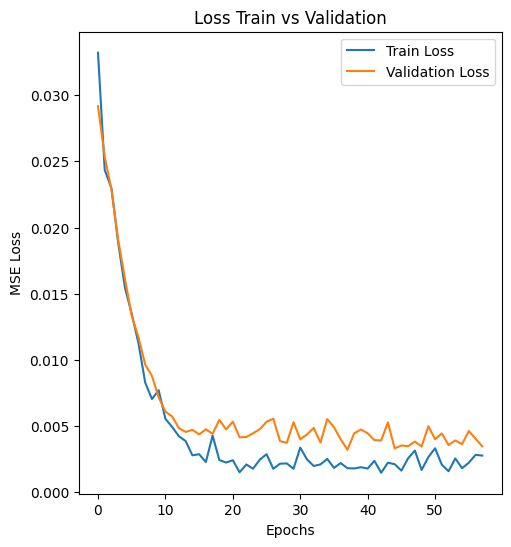

In [ ]:
# Gràfics d'evolució de l'entrenament
plt.figure(figsize=(12, 6))

# Gràfic de la pèrdua (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

In [ ]:
model.summary()

Model: "simple_pinn_tvdi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 3)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 3)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ merge_inputs (Concatenate)      │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_1 (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (LeakyReLU)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_2 (BatchNormalization)    │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (LeakyReLU)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_3 (BatchNormalization)    │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (LeakyReLU)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_TVDI (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,777 (557.73 KB)

 Trainable params: 47,293 (184.74 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 94,588 (369.49 KB)

In [14]:
import numpy as np
import pandas as pd
import time
from codecarbon import EmissionsTracker
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

os.makedirs("emissions", exist_ok=True)

alphas = [0.0, 0.1, 0.3, 0.5]
betas = [0.05, 0.1, 0.2]
beta_names = ['beta_T', 'beta_ETo', 'beta_I', 'beta_p', 'beta_pt']

resultats = []

tracker_total = EmissionsTracker(project_name="entrenament_total", output_dir="emissions")
tracker_total.start()
temps_total_inici = time.time()

for alpha_value in alphas:
    if alpha_value == 0.0:
        # NOMÉS una iteració amb totes les beta = 0
        beta_kwargs = {name: 0.0 for name in beta_names}

        tracker = EmissionsTracker(project_name=f"alpha_{alpha_value}_beta_zero", output_dir="emissions")
        tracker.start()
        inici = time.time()

        model = SimplePINN_TVDI(
            n_cat=len(le_cat.classes_),
            n_eam=len(le_eam.classes_),
            n_mes=12,
            alpha=alpha_value,
            **beta_kwargs
        )

        model.compile(optimizer=Adam(5e-4), loss='mse', metrics=['mae'])

        early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        history = model.fit(
            x=[X_num_train_scaled, X_cat_train, X_eam_train, X_mes_train],
            y=(y_train_scaled),
            validation_data=([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], (y_test_scaled)),
            epochs=300,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred_scaled = model.predict([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
        y_true_test = y_test.ravel()

        r2 = r2_score(y_true_test, y_pred)
        mae = mean_absolute_error(y_true_test, y_pred)
        r, _ = pearsonr(y_true_test, y_pred)
        mse = mean_squared_error(y_true_test, y_pred)
        rmse = np.sqrt(mse)

        emissions = tracker.stop()
        durada = time.time() - inici

        resultats.append({
            "alpha": alpha_value,
            **beta_kwargs,
            "val_loss": min(history.history["val_loss"]),
            "r2": r2,
            "mae": mae,
            "r": r,
            "mse": mse,
            "rmse": rmse,
            "emissions_kg": emissions,
            "temps_s": durada
        })

        print(f"[BASE] alpha=0.0, betas=0.0 -> R²={r2:.3f}, MAE={mae:.3f}, CO₂={emissions:.6f} kg, Temps={durada:.1f} s")

    else:
        # Totes les combinacions amb alpha > 0.0 i UNA beta activa
        for beta_name in beta_names:
            for beta_value in betas:
                beta_kwargs = {name: 0.0 for name in beta_names}
                beta_kwargs[beta_name] = beta_value

                tracker = EmissionsTracker(project_name=f"alpha_{alpha_value}_{beta_name}_{beta_value}", output_dir="emissions")
                tracker.start()
                inici = time.time()

                model = SimplePINN_TVDI(
                    n_cat=len(le_cat.classes_),
                    n_eam=len(le_eam.classes_),
                    n_mes=12,
                    alpha=alpha_value,
                    **beta_kwargs
                )

                model.compile(optimizer=Adam(5e-4), loss='mse', metrics=['mae'])

                early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

                history = model.fit(
                    x=[X_num_train_scaled, X_cat_train, X_eam_train, X_mes_train],
                    y=(y_train_scaled),
                    validation_data=([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], (y_test_scaled)),
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=0
                )

                y_pred_scaled = model.predict([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], verbose=0)
                y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
                y_true_test = y_test.ravel()

                r2 = r2_score(y_true_test, y_pred)
                mae = mean_absolute_error(y_true_test, y_pred)
                r, _ = pearsonr(y_true_test, y_pred)
                mse = mean_squared_error(y_true_test, y_pred)
                rmse = np.sqrt(mse)

                emissions = tracker.stop()
                durada = time.time() - inici

                resultats.append({
                    "alpha": alpha_value,
                    **beta_kwargs,
                    "val_loss": min(history.history["val_loss"]),
                    "r2": r2,
                    "mae": mae,
                    "r": r,
                    "mse": mse,
                    "rmse": rmse,
                    "emissions_kg": emissions,
                    "temps_s": durada
                })

                print(f"[{beta_name}] alpha={alpha_value}, beta={beta_value} -> R²={r2:.3f}, MAE={mae:.3f}, CO₂={emissions:.6f} kg, Temps={durada:.1f} s")

# Final global
emissions_total = tracker_total.stop()
temps_total = time.time() - temps_total_inici
print(f"\n[GLOBAL] Emissions totals: {emissions_total:.6f} kg, Temps total: {temps_total:.1f} s")

# Desa resultats
df_resultats = pd.DataFrame(resultats)
df_resultats.to_csv("resultats_entrenament_filtrat.csv", index=False)

[codecarbon WARNING @ 10:41:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:41:51] [setup] RAM Tracking...
[codecarbon INFO @ 10:41:51] [setup] CPU Tracking...
[codecarbon WARNING @ 10:41:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:41:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:41:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:41:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:41:52] [setup] GPU Tracking...
[codecarbon INFO @ 10:41:52] No GPU found.
[codecarbon INFO @ 10:41:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

[BASE] alpha=0.0, betas=0.0 -> R²=0.912, MAE=0.048, CO₂=0.000442 kg, Temps=138.9 s


[codecarbon WARNING @ 10:44:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:44:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:44:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:44:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:44:14] [setup] GPU Tracking...
[codecarbon INFO @ 10:44:14] No GPU found.
[codecarbon INFO @ 10:44:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:44:14] >>> Tracker's metadata:
[codecarbon INFO @ 10:44:14]   Platform system: Linux-6

[beta_T] alpha=0.1, beta=0.05 -> R²=0.905, MAE=0.051, CO₂=0.000431 kg, Temps=135.2 s


[codecarbon WARNING @ 10:46:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:46:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:46:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:46:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:46:30] [setup] GPU Tracking...
[codecarbon INFO @ 10:46:30] No GPU found.
[codecarbon INFO @ 10:46:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:46:30] >>> Tracker's metadata:
[codecarbon INFO @ 10:46:30]   Platform system: Linux-6

[beta_T] alpha=0.1, beta=0.1 -> R²=0.907, MAE=0.049, CO₂=0.000613 kg, Temps=192.3 s


[codecarbon WARNING @ 10:49:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:49:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:49:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:49:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:49:44] [setup] GPU Tracking...
[codecarbon INFO @ 10:49:44] No GPU found.
[codecarbon INFO @ 10:49:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:49:44] >>> Tracker's metadata:
[codecarbon INFO @ 10:49:44]   Platform system: Linux-6

[beta_T] alpha=0.1, beta=0.2 -> R²=0.908, MAE=0.049, CO₂=0.000728 kg, Temps=228.5 s


[codecarbon WARNING @ 10:53:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:53:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:53:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:53:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:53:34] [setup] GPU Tracking...
[codecarbon INFO @ 10:53:34] No GPU found.
[codecarbon INFO @ 10:53:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:53:34] >>> Tracker's metadata:
[codecarbon INFO @ 10:53:34]   Platform system: Linux-6

[beta_ETo] alpha=0.1, beta=0.05 -> R²=0.903, MAE=0.052, CO₂=0.000701 kg, Temps=220.0 s


[codecarbon WARNING @ 10:57:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:57:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:57:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 10:57:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:57:15] [setup] GPU Tracking...
[codecarbon INFO @ 10:57:15] No GPU found.
[codecarbon INFO @ 10:57:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 10:57:15] >>> Tracker's metadata:
[codecarbon INFO @ 10:57:15]   Platform system: Linux-6

[beta_ETo] alpha=0.1, beta=0.1 -> R²=0.906, MAE=0.050, CO₂=0.000717 kg, Temps=225.2 s


[codecarbon WARNING @ 11:01:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:01:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:01:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:01:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:01:01] [setup] GPU Tracking...
[codecarbon INFO @ 11:01:01] No GPU found.
[codecarbon INFO @ 11:01:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:01:01] >>> Tracker's metadata:
[codecarbon INFO @ 11:01:01]   Platform system: Linux-6

[beta_ETo] alpha=0.1, beta=0.2 -> R²=0.913, MAE=0.048, CO₂=0.000453 kg, Temps=142.1 s


[codecarbon INFO @ 11:03:25] Energy consumed for RAM : 0.003748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:03:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:25] Energy consumed for All CPU : 0.015934 kWh
[codecarbon INFO @ 11:03:25] 0.019682 kWh of electricity used since the beginning.
[codecarbon WARNING @ 11:03:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:03:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:03:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:03:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:03:25] [setup] GPU Tracking...
[codecarbon INFO @ 11:03:25] No GPU found.
[codecarbon IN

[beta_I] alpha=0.1, beta=0.05 -> R²=0.909, MAE=0.048, CO₂=0.000457 kg, Temps=143.6 s


[codecarbon WARNING @ 11:05:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:05:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:05:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:05:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:05:50] [setup] GPU Tracking...
[codecarbon INFO @ 11:05:50] No GPU found.
[codecarbon INFO @ 11:05:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:05:50] >>> Tracker's metadata:
[codecarbon INFO @ 11:05:50]   Platform system: Linux-6

[beta_I] alpha=0.1, beta=0.1 -> R²=0.901, MAE=0.052, CO₂=0.000607 kg, Temps=190.6 s


[codecarbon WARNING @ 11:09:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:09:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:09:02] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:09:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:09:02] [setup] GPU Tracking...
[codecarbon INFO @ 11:09:02] No GPU found.
[codecarbon INFO @ 11:09:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:09:02] >>> Tracker's metadata:
[codecarbon INFO @ 11:09:02]   Platform system: Linux-6

[beta_I] alpha=0.1, beta=0.2 -> R²=0.912, MAE=0.048, CO₂=0.000320 kg, Temps=100.6 s


[codecarbon WARNING @ 11:10:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:10:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:10:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:10:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:10:44] [setup] GPU Tracking...
[codecarbon INFO @ 11:10:44] No GPU found.
[codecarbon INFO @ 11:10:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:10:44] >>> Tracker's metadata:
[codecarbon INFO @ 11:10:44]   Platform system: Linux-6

[beta_p] alpha=0.1, beta=0.05 -> R²=0.911, MAE=0.049, CO₂=0.000398 kg, Temps=125.0 s


[codecarbon WARNING @ 11:12:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:12:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:12:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:12:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:12:50] [setup] GPU Tracking...
[codecarbon INFO @ 11:12:50] No GPU found.
[codecarbon INFO @ 11:12:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:12:50] >>> Tracker's metadata:
[codecarbon INFO @ 11:12:50]   Platform system: Linux-6

[beta_p] alpha=0.1, beta=0.1 -> R²=0.910, MAE=0.049, CO₂=0.000478 kg, Temps=150.1 s


[codecarbon WARNING @ 11:15:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:15:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:15:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:15:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:15:21] [setup] GPU Tracking...
[codecarbon INFO @ 11:15:21] No GPU found.
[codecarbon INFO @ 11:15:21] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:15:21] >>> Tracker's metadata:
[codecarbon INFO @ 11:15:21]   Platform system: Linux-6

[beta_p] alpha=0.1, beta=0.2 -> R²=0.905, MAE=0.050, CO₂=0.000545 kg, Temps=171.0 s


[codecarbon WARNING @ 11:18:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:18:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:18:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:18:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:18:14] [setup] GPU Tracking...
[codecarbon INFO @ 11:18:14] No GPU found.
[codecarbon INFO @ 11:18:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:18:14] >>> Tracker's metadata:
[codecarbon INFO @ 11:18:14]   Platform system: Linux-6

[beta_pt] alpha=0.1, beta=0.05 -> R²=0.907, MAE=0.050, CO₂=0.000424 kg, Temps=133.1 s


[codecarbon WARNING @ 11:20:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:20:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:20:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:20:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:20:28] [setup] GPU Tracking...
[codecarbon INFO @ 11:20:28] No GPU found.
[codecarbon INFO @ 11:20:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:20:28] >>> Tracker's metadata:
[codecarbon INFO @ 11:20:28]   Platform system: Linux-6

[beta_pt] alpha=0.1, beta=0.1 -> R²=0.909, MAE=0.049, CO₂=0.000635 kg, Temps=199.2 s


[codecarbon WARNING @ 11:23:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:23:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:23:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:23:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:23:49] [setup] GPU Tracking...
[codecarbon INFO @ 11:23:49] No GPU found.
[codecarbon INFO @ 11:23:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:23:49] >>> Tracker's metadata:
[codecarbon INFO @ 11:23:49]   Platform system: Linux-6

[beta_pt] alpha=0.1, beta=0.2 -> R²=0.891, MAE=0.056, CO₂=0.000447 kg, Temps=140.5 s


[codecarbon INFO @ 11:26:10] Energy consumed for RAM : 0.007538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:26:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:10] Energy consumed for All CPU : 0.032044 kWh
[codecarbon INFO @ 11:26:10] 0.039582 kWh of electricity used since the beginning.
[codecarbon WARNING @ 11:26:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:26:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:26:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:26:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:26:10] [setup] GPU Tracking...
[codecarbon INFO @ 11:26:10] No GPU found.
[codecarbon IN

[beta_T] alpha=0.3, beta=0.05 -> R²=0.907, MAE=0.049, CO₂=0.000623 kg, Temps=195.4 s


[codecarbon WARNING @ 11:29:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:29:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:29:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:29:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:29:27] [setup] GPU Tracking...
[codecarbon INFO @ 11:29:27] No GPU found.
[codecarbon INFO @ 11:29:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:29:27] >>> Tracker's metadata:
[codecarbon INFO @ 11:29:27]   Platform system: Linux-6

[beta_T] alpha=0.3, beta=0.1 -> R²=0.902, MAE=0.051, CO₂=0.000594 kg, Temps=186.5 s


[codecarbon WARNING @ 11:32:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:32:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:32:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:32:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:32:35] [setup] GPU Tracking...
[codecarbon INFO @ 11:32:35] No GPU found.
[codecarbon INFO @ 11:32:35] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:32:35] >>> Tracker's metadata:
[codecarbon INFO @ 11:32:35]   Platform system: Linux-6

[beta_T] alpha=0.3, beta=0.2 -> R²=0.904, MAE=0.051, CO₂=0.000579 kg, Temps=181.9 s


[codecarbon INFO @ 11:35:38] Energy consumed for RAM : 0.008953 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:35:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:38] Energy consumed for All CPU : 0.038062 kWh
[codecarbon INFO @ 11:35:38] 0.047015 kWh of electricity used since the beginning.
[codecarbon WARNING @ 11:35:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:35:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:35:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:35:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:35:38] [setup] GPU Tracking...
[codecarbon INFO @ 11:35:38] No GPU found.
[codecarbon IN

[beta_ETo] alpha=0.3, beta=0.05 -> R²=0.905, MAE=0.050, CO₂=0.000542 kg, Temps=170.1 s


[codecarbon WARNING @ 11:38:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:38:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:38:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:38:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:38:30] [setup] GPU Tracking...
[codecarbon INFO @ 11:38:30] No GPU found.
[codecarbon INFO @ 11:38:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:38:30] >>> Tracker's metadata:
[codecarbon INFO @ 11:38:30]   Platform system: Linux-6

[beta_ETo] alpha=0.3, beta=0.1 -> R²=0.912, MAE=0.048, CO₂=0.000588 kg, Temps=184.6 s


[codecarbon WARNING @ 11:41:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:41:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:41:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:41:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:41:36] [setup] GPU Tracking...
[codecarbon INFO @ 11:41:36] No GPU found.
[codecarbon INFO @ 11:41:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:41:36] >>> Tracker's metadata:
[codecarbon INFO @ 11:41:36]   Platform system: Linux-6

[beta_ETo] alpha=0.3, beta=0.2 -> R²=0.906, MAE=0.050, CO₂=0.000579 kg, Temps=181.9 s


[codecarbon INFO @ 11:44:38] Energy consumed for RAM : 0.010452 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:44:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:38] Energy consumed for All CPU : 0.044434 kWh
[codecarbon INFO @ 11:44:38] 0.054887 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:44:39] Energy consumed for RAM : 0.010620 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 11:44:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:39] Energy consumed for All CPU : 0.045147 kWh
[codecarbon INFO @ 11:44:39] 0.055768 kWh of electricity used since the beginning.
[codecarbon WARNING @ 11:44:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:44:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powe

[beta_I] alpha=0.3, beta=0.05 -> R²=0.905, MAE=0.050, CO₂=0.000542 kg, Temps=170.1 s


[codecarbon WARNING @ 11:47:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:47:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:47:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:47:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:47:30] [setup] GPU Tracking...
[codecarbon INFO @ 11:47:30] No GPU found.
[codecarbon INFO @ 11:47:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:47:30] >>> Tracker's metadata:
[codecarbon INFO @ 11:47:30]   Platform system: Linux-6

[beta_I] alpha=0.3, beta=0.1 -> R²=0.907, MAE=0.049, CO₂=0.000509 kg, Temps=159.8 s


[codecarbon WARNING @ 11:50:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:50:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:50:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:50:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:50:12] [setup] GPU Tracking...
[codecarbon INFO @ 11:50:12] No GPU found.
[codecarbon INFO @ 11:50:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:50:12] >>> Tracker's metadata:
[codecarbon INFO @ 11:50:12]   Platform system: Linux-6

[beta_I] alpha=0.3, beta=0.2 -> R²=0.912, MAE=0.048, CO₂=0.000772 kg, Temps=242.3 s


[codecarbon WARNING @ 11:54:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:54:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:54:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:54:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:54:15] [setup] GPU Tracking...
[codecarbon INFO @ 11:54:15] No GPU found.
[codecarbon INFO @ 11:54:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:54:15] >>> Tracker's metadata:
[codecarbon INFO @ 11:54:15]   Platform system: Linux-6

[beta_p] alpha=0.3, beta=0.05 -> R²=0.903, MAE=0.051, CO₂=0.000521 kg, Temps=163.5 s


[codecarbon WARNING @ 11:57:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:57:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:57:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 11:57:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:57:00] [setup] GPU Tracking...
[codecarbon INFO @ 11:57:00] No GPU found.
[codecarbon INFO @ 11:57:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:57:00] >>> Tracker's metadata:
[codecarbon INFO @ 11:57:00]   Platform system: Linux-6

[beta_p] alpha=0.3, beta=0.1 -> R²=0.903, MAE=0.050, CO₂=0.000941 kg, Temps=295.4 s


[codecarbon WARNING @ 12:01:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:01:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:01:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:01:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:01:57] [setup] GPU Tracking...
[codecarbon INFO @ 12:01:57] No GPU found.
[codecarbon INFO @ 12:01:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:01:57] >>> Tracker's metadata:
[codecarbon INFO @ 12:01:57]   Platform system: Linux-6

[beta_p] alpha=0.3, beta=0.2 -> R²=0.910, MAE=0.048, CO₂=0.000440 kg, Temps=138.2 s


[codecarbon WARNING @ 12:04:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:04:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:04:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:04:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:04:17] [setup] GPU Tracking...
[codecarbon INFO @ 12:04:17] No GPU found.
[codecarbon INFO @ 12:04:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:04:17] >>> Tracker's metadata:
[codecarbon INFO @ 12:04:17]   Platform system: Linux-6

[beta_pt] alpha=0.3, beta=0.05 -> R²=0.906, MAE=0.050, CO₂=0.000456 kg, Temps=143.3 s


[codecarbon INFO @ 12:06:41] Energy consumed for RAM : 0.014284 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:06:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:06:41] Energy consumed for All CPU : 0.060724 kWh
[codecarbon INFO @ 12:06:41] 0.075008 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:06:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:06:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:06:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:06:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:06:41] [setup] GPU Tracking...
[codecarbon INFO @ 12:06:41] No GPU found.
[codecarbon IN

[beta_pt] alpha=0.3, beta=0.1 -> R²=0.911, MAE=0.048, CO₂=0.000416 kg, Temps=130.6 s


[codecarbon INFO @ 12:08:53] Energy consumed for RAM : 0.014492 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:08:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:08:53] Energy consumed for All CPU : 0.061605 kWh
[codecarbon INFO @ 12:08:53] 0.076097 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:08:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:08:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:08:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:08:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:08:53] [setup] GPU Tracking...
[codecarbon INFO @ 12:08:53] No GPU found.
[codecarbon IN

[beta_pt] alpha=0.3, beta=0.2 -> R²=0.894, MAE=0.054, CO₂=0.000496 kg, Temps=155.7 s


[codecarbon WARNING @ 12:11:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:11:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:11:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:11:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:11:30] [setup] GPU Tracking...
[codecarbon INFO @ 12:11:30] No GPU found.
[codecarbon INFO @ 12:11:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:11:30] >>> Tracker's metadata:
[codecarbon INFO @ 12:11:30]   Platform system: Linux-6

[beta_T] alpha=0.5, beta=0.05 -> R²=0.908, MAE=0.050, CO₂=0.000595 kg, Temps=186.9 s


[codecarbon INFO @ 12:14:38] Energy consumed for RAM : 0.015449 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:14:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:14:38] Energy consumed for All CPU : 0.065676 kWh
[codecarbon INFO @ 12:14:38] 0.081126 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:14:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:14:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:14:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:14:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:14:39] [setup] GPU Tracking...
[codecarbon INFO @ 12:14:39] No GPU found.
[codecarbon IN

[beta_T] alpha=0.5, beta=0.1 -> R²=0.907, MAE=0.050, CO₂=0.000648 kg, Temps=203.5 s


[codecarbon WARNING @ 12:18:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:18:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:18:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:18:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:18:03] [setup] GPU Tracking...
[codecarbon INFO @ 12:18:03] No GPU found.
[codecarbon INFO @ 12:18:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:18:03] >>> Tracker's metadata:
[codecarbon INFO @ 12:18:03]   Platform system: Linux-6

[beta_T] alpha=0.5, beta=0.2 -> R²=0.910, MAE=0.049, CO₂=0.000504 kg, Temps=158.1 s


[codecarbon WARNING @ 12:20:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:20:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:20:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:20:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:20:43] [setup] GPU Tracking...
[codecarbon INFO @ 12:20:43] No GPU found.
[codecarbon INFO @ 12:20:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:20:43] >>> Tracker's metadata:
[codecarbon INFO @ 12:20:43]   Platform system: Linux-6

[beta_ETo] alpha=0.5, beta=0.05 -> R²=0.910, MAE=0.049, CO₂=0.000451 kg, Temps=141.5 s


[codecarbon WARNING @ 12:23:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:23:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:06] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:06] No GPU found.
[codecarbon INFO @ 12:23:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:23:06] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:06]   Platform system: Linux-6

[beta_ETo] alpha=0.5, beta=0.1 -> R²=0.905, MAE=0.050, CO₂=0.000683 kg, Temps=214.5 s


[codecarbon INFO @ 12:26:41] Energy consumed for RAM : 0.017616 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:26:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:26:41] Energy consumed for All CPU : 0.074885 kWh
[codecarbon INFO @ 12:26:41] 0.092501 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:26:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:26:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:26:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:26:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:26:41] [setup] GPU Tracking...
[codecarbon INFO @ 12:26:41] No GPU found.
[codecarbon IN

[beta_ETo] alpha=0.5, beta=0.2 -> R²=0.903, MAE=0.051, CO₂=0.000833 kg, Temps=261.5 s


[codecarbon WARNING @ 12:31:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:31:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:31:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:31:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:31:04] [setup] GPU Tracking...
[codecarbon INFO @ 12:31:04] No GPU found.
[codecarbon INFO @ 12:31:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:31:04] >>> Tracker's metadata:
[codecarbon INFO @ 12:31:04]   Platform system: Linux-6

[beta_I] alpha=0.5, beta=0.05 -> R²=0.909, MAE=0.050, CO₂=0.000416 kg, Temps=130.6 s


[codecarbon WARNING @ 12:33:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:33:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:33:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:33:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:33:16] [setup] GPU Tracking...
[codecarbon INFO @ 12:33:16] No GPU found.
[codecarbon INFO @ 12:33:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:33:16] >>> Tracker's metadata:
[codecarbon INFO @ 12:33:16]   Platform system: Linux-6

[beta_I] alpha=0.5, beta=0.1 -> R²=0.905, MAE=0.050, CO₂=0.000875 kg, Temps=274.9 s


[codecarbon WARNING @ 12:37:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:37:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:37:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:37:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:37:52] [setup] GPU Tracking...
[codecarbon INFO @ 12:37:52] No GPU found.
[codecarbon INFO @ 12:37:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:37:52] >>> Tracker's metadata:
[codecarbon INFO @ 12:37:52]   Platform system: Linux-6

[beta_I] alpha=0.5, beta=0.2 -> R²=0.913, MAE=0.048, CO₂=0.000405 kg, Temps=127.0 s


[codecarbon WARNING @ 12:40:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:40:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:40:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:40:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:40:01] [setup] GPU Tracking...
[codecarbon INFO @ 12:40:01] No GPU found.
[codecarbon INFO @ 12:40:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:40:01] >>> Tracker's metadata:
[codecarbon INFO @ 12:40:01]   Platform system: Linux-6

[beta_p] alpha=0.5, beta=0.05 -> R²=0.905, MAE=0.049, CO₂=0.000708 kg, Temps=222.3 s


[codecarbon WARNING @ 12:43:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:43:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:43:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:43:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:43:45] [setup] GPU Tracking...
[codecarbon INFO @ 12:43:45] No GPU found.
[codecarbon INFO @ 12:43:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:43:45] >>> Tracker's metadata:
[codecarbon INFO @ 12:43:45]   Platform system: Linux-6

[beta_p] alpha=0.5, beta=0.1 -> R²=0.905, MAE=0.050, CO₂=0.000894 kg, Temps=280.8 s


[codecarbon INFO @ 12:48:26] Energy consumed for RAM : 0.021238 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:48:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:26] Energy consumed for All CPU : 0.090287 kWh
[codecarbon INFO @ 12:48:26] 0.111525 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:48:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:48:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:48:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:48:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:48:27] [setup] GPU Tracking...
[codecarbon INFO @ 12:48:27] No GPU found.
[codecarbon IN

[beta_p] alpha=0.5, beta=0.2 -> R²=0.908, MAE=0.049, CO₂=0.000813 kg, Temps=255.4 s


[codecarbon WARNING @ 12:52:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:52:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:52:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:52:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:52:44] [setup] GPU Tracking...
[codecarbon INFO @ 12:52:44] No GPU found.
[codecarbon INFO @ 12:52:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:52:44] >>> Tracker's metadata:
[codecarbon INFO @ 12:52:44]   Platform system: Linux-6

[beta_pt] alpha=0.5, beta=0.05 -> R²=0.906, MAE=0.050, CO₂=0.000570 kg, Temps=179.1 s


[codecarbon WARNING @ 12:55:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:55:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:55:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:55:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:55:44] [setup] GPU Tracking...
[codecarbon INFO @ 12:55:44] No GPU found.
[codecarbon INFO @ 12:55:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:55:44] >>> Tracker's metadata:
[codecarbon INFO @ 12:55:44]   Platform system: Linux-6

[beta_pt] alpha=0.5, beta=0.1 -> R²=0.907, MAE=0.050, CO₂=0.000445 kg, Temps=139.7 s


[codecarbon WARNING @ 12:58:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:58:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:58:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 12:58:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:58:05] [setup] GPU Tracking...
[codecarbon INFO @ 12:58:05] No GPU found.
[codecarbon INFO @ 12:58:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 12:58:05] >>> Tracker's metadata:
[codecarbon INFO @ 12:58:05]   Platform system: Linux-6

[beta_pt] alpha=0.5, beta=0.2 -> R²=0.912, MAE=0.048, CO₂=0.000395 kg, Temps=124.1 s

[GLOBAL] Emissions totals: 0.026427 kg, Temps total: 8297.1 s


In [16]:
df_resultats.head()

,alpha,beta_T,beta_ETo,beta_I,beta_p,beta_pt,val_loss,r2,mae,r,mse,rmse,emissions_kg,temps_s
0,0.0,0.00,0.00,0.0,0.0,0.0,0.003076,0.911811,0.047915,0.956031,0.004137,0.064316,0.000442,138.891721
1,0.1,0.05,0.00,0.0,0.0,0.0,0.002843,0.905426,0.050513,0.956045,0.004436,0.066604,0.000431,135.194085
2,0.1,0.10,0.00,0.0,0.0,0.0,0.002827,0.906728,0.049365,0.955289,0.004375,0.066144,0.000613,192.340177
3,0.1,0.20,0.00,0.0,0.0,0.0,0.002822,0.907875,0.049210,0.955401,0.004321,0.065736,0.000728,228.473499
4,0.1,0.00,0.05,0.0,0.0,0.0,0.002902,0.903021,0.051582,0.955941,0.004549,0.067445,0.000701,219.955387
